# *Яндекс ПРАКТИКУМ*

# **ПРОЕКТ: Определение возраста покупателей**

# Выполнил: *Мирослав Г.*

# email:

# Дата: 08.2023

## Исследовательский анализ данных

Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.head(5))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Информация о датасете

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Как видно, общее количество фото в датасете недостаточно для высококачественного обучения модели, т.к. возрастных критериев - 100, то на каждый критерий (при равномерном распределении) приходилось бы около 75 фото. Можно предпопложить, что распределение будет стремиться к нормальному, из чего следует, что для некоторых категорий возраста количество фото будет не достаточно.
Для более качественного предсказания, лучше применить предобученную модель, или увелчить объем датасета.

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


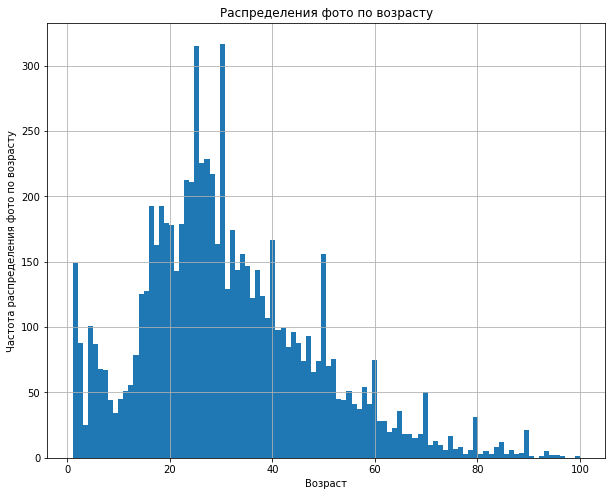

In [5]:
plt.figure(figsize=(10,8))
labels['real_age'].hist(bins=100);
plt.xlabel('Возраст')
plt.ylabel('Частота распределения фото по возрасту')
plt.title('Распределения фото по возрасту')
plt.show()

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [7]:
features,target=next(gen_flow)

In [8]:
features.shape

(32, 224, 224, 3)

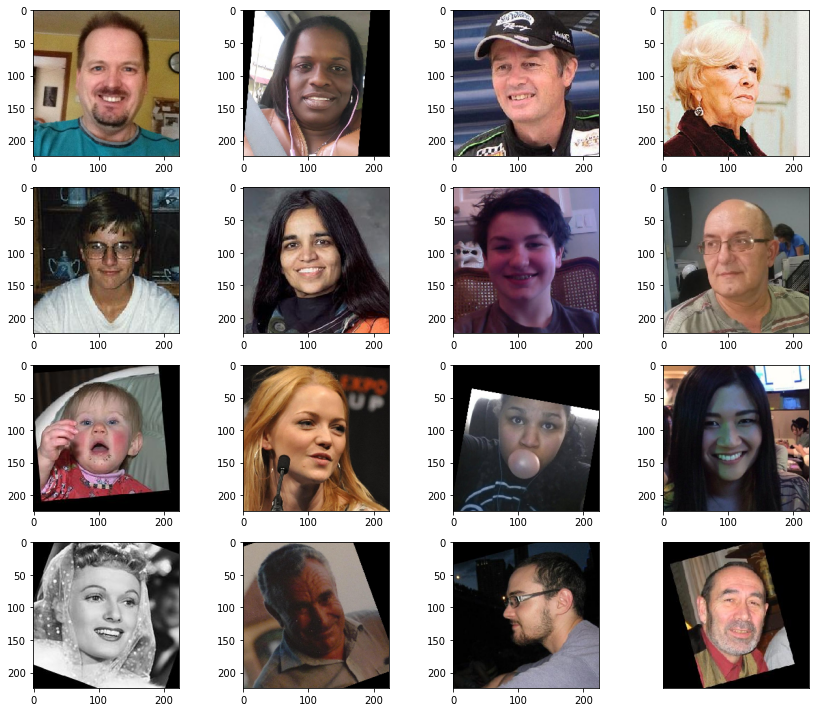

In [9]:
fig = plt.figure(figsize=(12, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([]) # убираем подписи по оси х
    plt.yticks([]) # убираем подписи по оси у
    plt.tight_layout() # убираем отступы между фотографиями
    plt.show()

**Вывод:**\
Представленный датасет состоит из 2 колонок и 7591 строк.\
Пропусков и неадекватных данных в колонке "real_age"- нет.\
Распределение данных близко к нормальному с усечением в левой стороне.\
Средний возраст респондентов на фото 31,2 года. \
Максимальный возраст 100 лет и минимальный 1 год.\
50% респондентов младше 29 лет, включительно. Это говорит о меньшей плотности распределения фотографий соответствующих старшим возрастам, что может повлиять на качество обучения модели на фото пожилых людей. 
Фотографии имеют различное качество, цветные и черно-белые, лица расположены под разным углом и смотрят в сторону от объектива. Что негативно повлияет на качество обучения модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [10]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
                                        validation_split=0.25,
                                        horizontal_flip=True, 
                                        rotation_range=20,
                                        rescale=1./255          
                                        )
    train_gen_flow = train_datagen.flow_from_dataframe(
                                                        dataframe=labels,
                                                        directory=path + '/final_files/',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='raw',
                                                        subset='training',
                                                        seed=12345                          
                                                        )
    return train_gen_flow

In [11]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
                                        validation_split=0.25,
                                        rescale=1./255          
                                        )
    test_gen_flow = test_datagen.flow_from_dataframe(
                                                    dataframe=labels,
                                                    directory=path + '/final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345
                                                    )
    return test_gen_flow

In [12]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 115s - loss: 274.0348 - mae: 11.9720 - val_loss: 522.9146 - val_mae: 17.8273
Epoch 2/10
178/178 - 92s - loss: 95.0707 - mae: 7.3462 - val_loss: 537.1085 - val_mae: 18.0834
Epoch 3/10
178/178 - 92s - loss: 72.9704 - mae: 6.5069 - val_loss: 234.7954 - val_mae: 11.2365
Epoch 4/10
178/178 - 101s - loss: 57.9908 - mae: 5.8221 - val_loss: 132.7686 - val_mae: 8.7249
Epoch 5/10
178/178 - 102s - loss: 45.9478 - mae: 5.1771 - val_loss: 83.1138 - val_mae: 6.7333
Epoch 6/10
178/178 - 97s - loss: 37.6948 - mae: 4.6992 - val_loss: 112.5007 - val_mae: 7.9499
Epoch 7/10
178/178 - 89s - loss: 33.4653 - mae: 4.4576 - val_loss: 68.8221 - val_mae: 6.0626
Epoch 8/10
178/178 - 95s - loss: 29.3627 - mae: 4.1826 - val_loss: 63.6068 - val_mae: 5.9478
Epoch 9/10
178/178 - 98s - loss: 24.8955 - mae: 3.8452 - val_loss: 76.0603 - val_mae: 6.7067
Epoch 10/10
178/178 - 98s - loss: 23.0066 - mae: 3.6963 - val_loss: 70.3226 - val_mae: 6.1651

60/60 - 10s - loss: 70.3226 - mae: 6.1651
Test MAE: 6.1651
```

*Модель обучена и преодолела планку требуемой точности*

## Анализ обученной модели

Для выполнения поставленной задачи был представлен датасет, состоящий из 2 колонок и 7591 строк.\
Пропусков и неадекватных данных в колонке "real_age"- нет.\
Распределение данных близко к нормальному с усечением в левой стороне.\
Средний возраст респондентов на фото 31,2 года.\
Максимальный возраст 100 лет и минимальный 1 год.\
50% респондентов младше 29 лет, включительно. Это говорит о меньшей плотности распределения фотографий соответствующих старшим возрастам, что может повлиять на качество обучения модели на фото пожилых людей. 

Количества фото в датасете недостаточно для высококачественного прогнозирования обученной модели, поэтому для улучшения качества предсказания, рекомендовали применить предобученную модель, или увелчить объем датасета.

Фотографии имеют различное качество, есть и цветные и черно-белые, на некоторых фото лица расположены под разным углом и смотрят в сторону от объектива. Что негативно повлияет на качество обучения модели.

В связи с вышеизложенным, для повышения качества обучения, применили Аугментации: горизонтальное отражение и поворот на 20 град.

Для прогнозирования возраста клиентов выбрали модель сверточной нейронной сети с архитектурой ResNet50. \
Модель ResNet50 возникла, чтобы решить проблему затухающего градиента в очень глубоких сетях.\
Эта модель предобучена на ImageNet (ImageNet - это база данных изображений, организованная в соответствии с иерархией WordNet, в которой каждый узел иерархии изображен сотнями и тысячами изображений), на котором сеть обучалась классифицировать изображения на 1000 классов.

В конце архитектуры ResNet по умолчанию включены два слоя: GlobalAveragePooling2d и Dense, которые необходимо было пересоздать для адаптации к текущим параметрам. ДЛя этого убрали верхушку и сконструировали её заново, добавив слои: 
- первый слой - GlobalAveragePooling2d, выводит среднее значение по всей марице пикселей для всех каналов, и имеет размер окна равный размеру матрицы (вектора, тензора);
- второй слой - Dense, полносвязный слой с активацией "relu".

При оптимизации применили функцию для нахождения минимума - Adam с шагом lr=0.0001.

При обучении модели было задано 10 эпох. При данном количестве эпох переобучения достигнуто небыло. Дальнейшее увеличение кол-ва эпох приводило к переобучению.

Результат обучения модели показал значение метрики MAE на тестовой выборке - 6.17.\
На мой взгляд это неудовлетворительный результат для поставленной задачи, так как абсолютная средняя ошибка более чем на 6 лет, при определении категории несовершеннолетних лиц, с целью запрета продажи алкоголя и сигарет, может привести к нарушению законодательства.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы